# Курс Специализация Data Science Дипломный проект. Бриф учебного кейса 
## «Модель прогнозирования стоимости жилья для агентства недвижимости»

### 2 Этап Анализ данных

In [164]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [194]:
# функция для визуализации распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [196]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [124]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

## Описание данных:
* 'status' — статус продажи;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'city' — город;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'state' — штат;
* target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).
* 'pool_encoded' — наличие собственного бассейна;
* 'Type' — тип объекта недвижимости;
* 'Year built' - год постройки;
* 'Heating_encoded' - наличие отопления;
* 'Cooling_encoded' - наличие кондиционера;
* 'Parking_encoded' - наличие парковки/гаража;
* 'fireplace_encoded' - наличие камина;
* 'school_rating _mean' - средний рейтинг школ рядом;
* 'school_dist_min' - Минимальное растояние до школы;


# Подгрузим предобработанный датасет

In [169]:
df = pd.read_csv('data/cleaned_data.csv')
display(df.head())
df.info()

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
0,Active,240 Heather Ln,4.0,Southern Pines,2900,28387,NC,418000,False,single_family_home,2019,True,False,False,True,5.2,2.70
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,single_family_home,2019,False,False,False,False,4.0,1.01
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
4,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331844 entries, 0 to 331843
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331844 non-null  object 
 1   street               331844 non-null  object 
 2   baths                331844 non-null  float64
 3   city                 331844 non-null  object 
 4   sqft                 331844 non-null  int64  
 5   zipcode              331844 non-null  int64  
 6   state                331844 non-null  object 
 7   target               331844 non-null  int64  
 8   pool_encoded         331844 non-null  bool   
 9   Type                 331844 non-null  object 
 10  Year built           331844 non-null  object 
 11  Heating_encoded      331844 non-null  bool   
 12  Cooling_encoded      331844 non-null  bool   
 13  Parking_encoded      331844 non-null  bool   
 14  fireplace_encoded    331844 non-null  bool   
 15  school_rating _me

После подгрузки предобработанного файла признак zipcode стал числовым, что не совсем корректно так как zipcode указывает нам на район расположения объекта исправим это и приступим посмотрим на выбросы в числовых данных

In [170]:
df['zipcode'] = df['zipcode'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331844 entries, 0 to 331843
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               331844 non-null  object 
 1   street               331844 non-null  object 
 2   baths                331844 non-null  float64
 3   city                 331844 non-null  object 
 4   sqft                 331844 non-null  int64  
 5   zipcode              331844 non-null  object 
 6   state                331844 non-null  object 
 7   target               331844 non-null  int64  
 8   pool_encoded         331844 non-null  bool   
 9   Type                 331844 non-null  object 
 10  Year built           331844 non-null  object 
 11  Heating_encoded      331844 non-null  bool   
 12  Cooling_encoded      331844 non-null  bool   
 13  Parking_encoded      331844 non-null  bool   
 14  fireplace_encoded    331844 non-null  bool   
 15  school_rating _me

In [171]:
# Составим список булевых признаков:
bin_features = ['pool_encoded','Heating_encoded','Cooling_encoded','Parking_encoded','fireplace_encoded']

# Составим список категориальных признаков:
cat_features = ['status','city','zipcode','state','Type','Year built']
 
# Составим список числовых признаков:
num_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

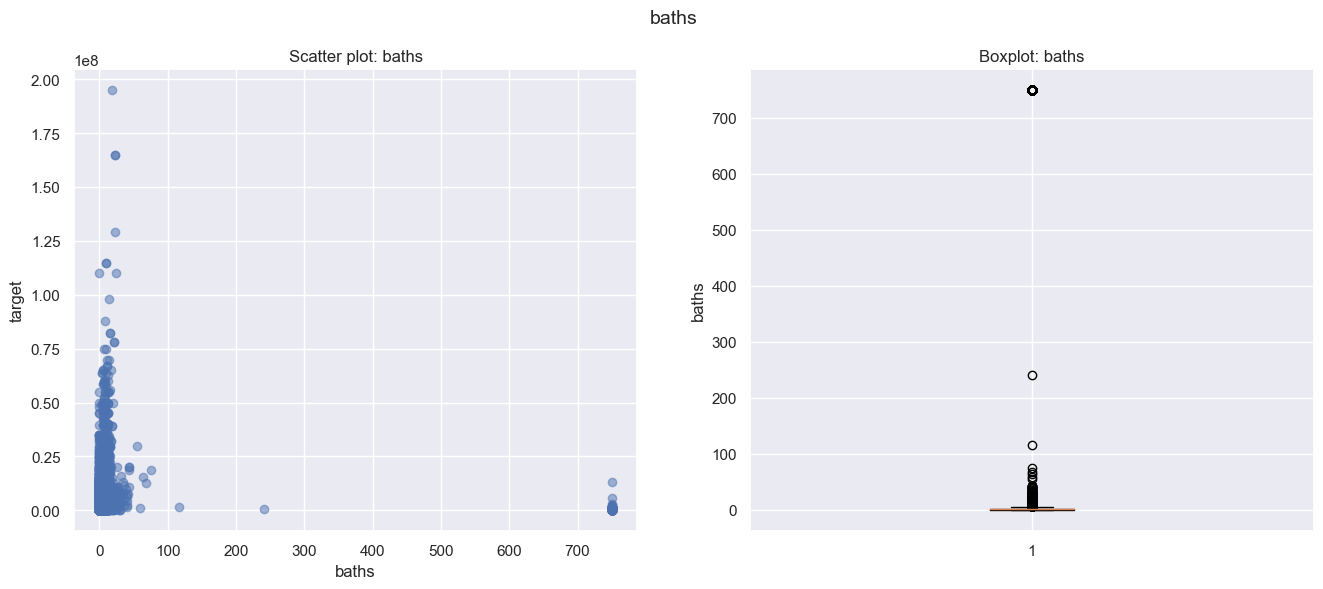

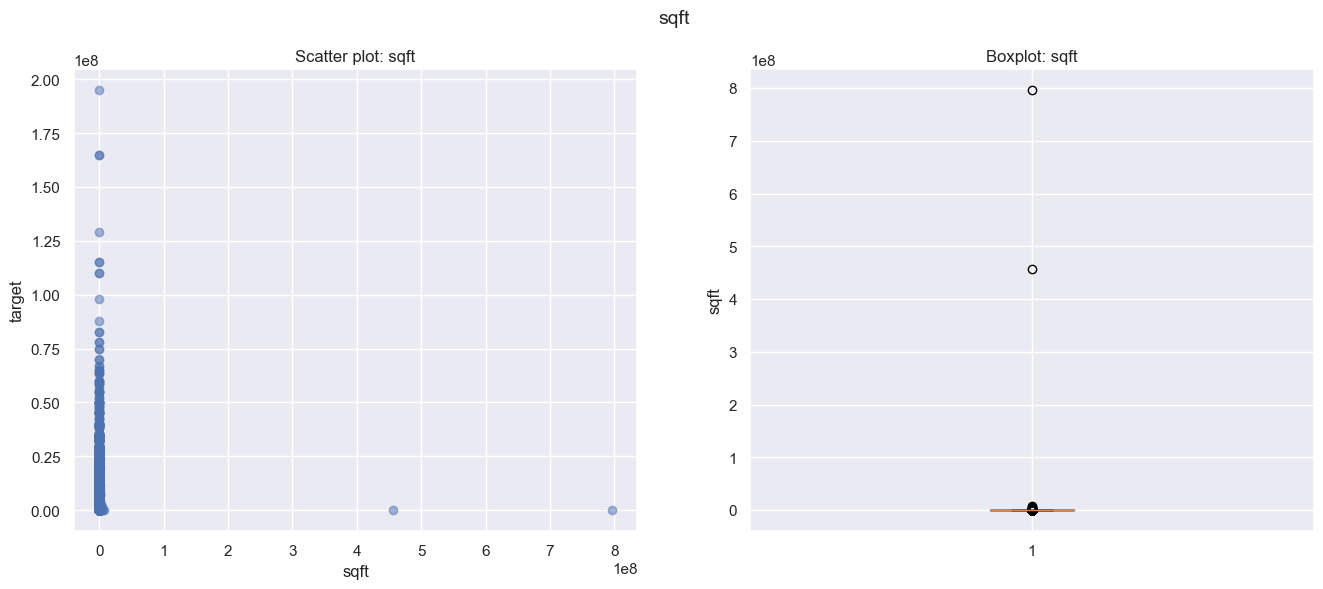

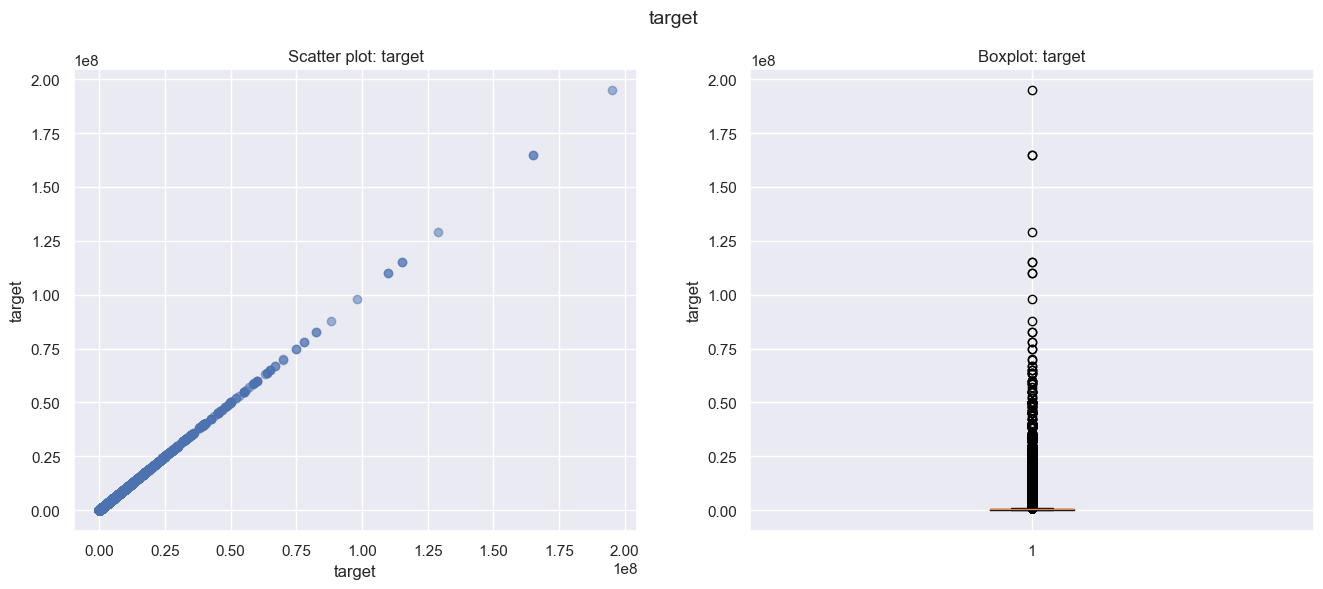

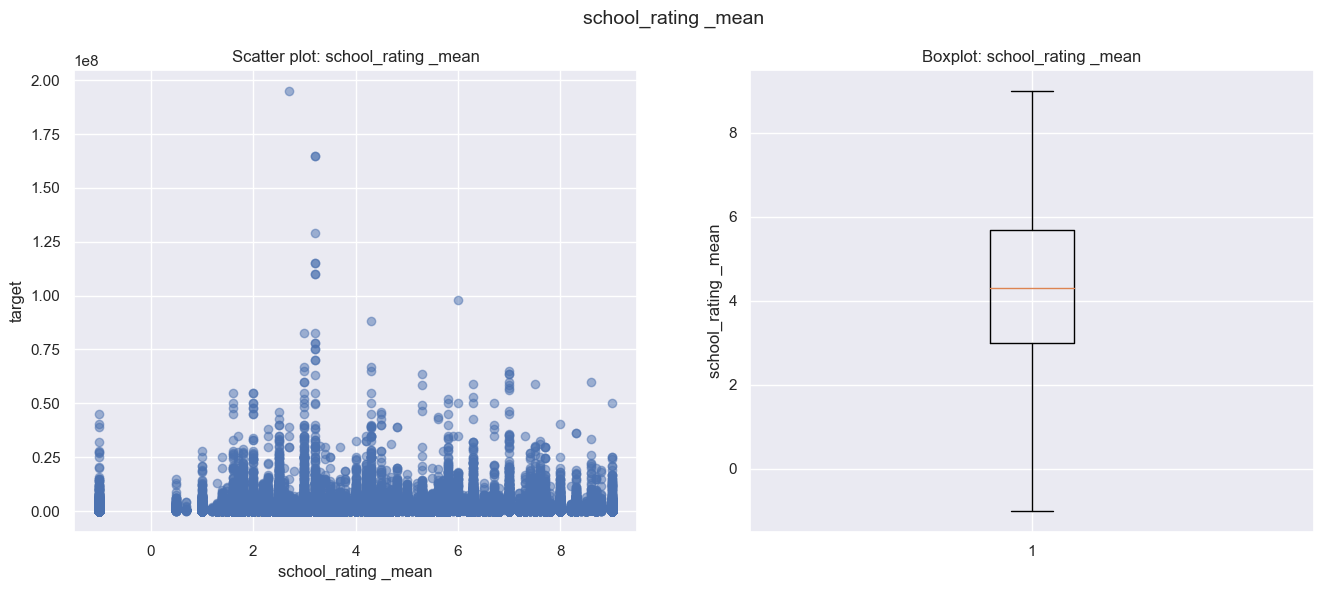

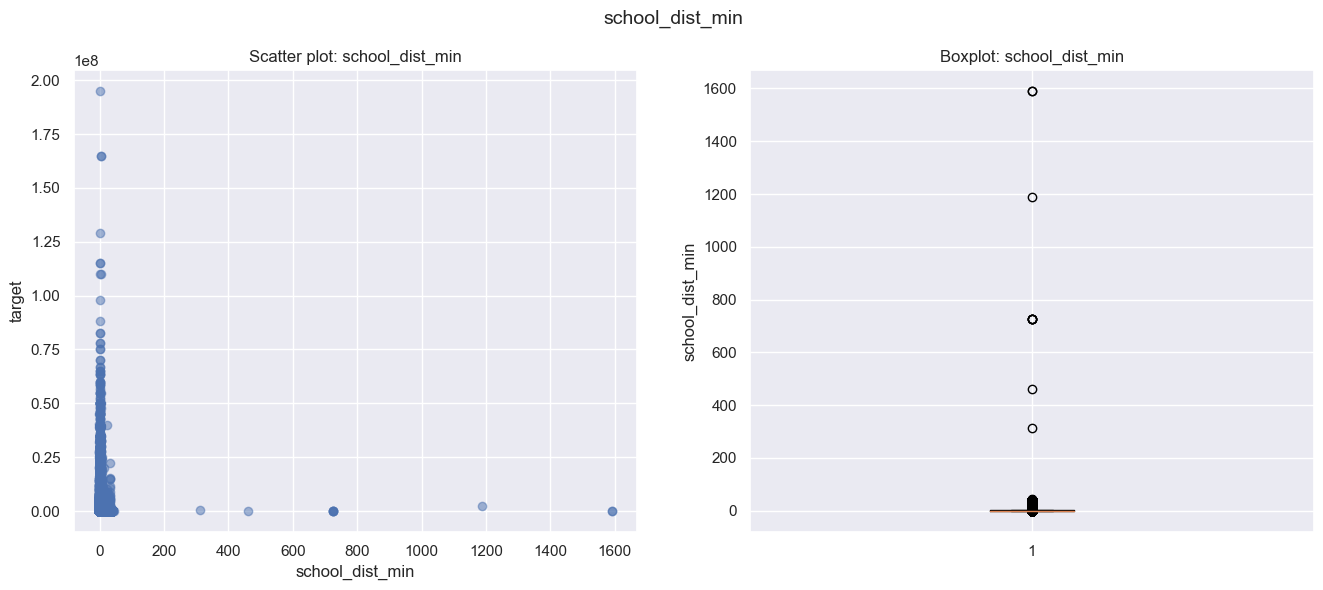

In [173]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

* По ванным комнатам нужно посмотреть 116 241 и 750 ванных комнат, слижком низкая цена при таком колличестве, 
* По площади нужно посмотреть значения 0 и цена 195 милионов а так же площади больше 456
* по школам растояния больше 200

In [129]:
# выведем интересующие нас строки
condition = (df['baths'].isin([116,241,750]))
filtered_df = df[condition]
# Вывести отфильтрованные строки
display(filtered_df)
# Подсчет среднего значения 'sqft'
average_sqft = filtered_df['sqft'].mean()
# Вывести среднее значение 'sqft'
print("Среднее значение sqft: ", average_sqft)

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
981,Active,3624 Douglas Ave,750.0,Dallas,1758,75219,TX,499000,False,other,1993,False,True,False,True,2.6,0.9
1788,Active,920 I St NW #411,750.0,Washington,1367,20001,DC,1499000,False,other,2013,False,False,False,False,6.8,0.3
3157,Active,601 W 11th Ave #409,750.0,Denver,873,80204,CO,348900,False,other,1981,True,True,False,False,4.0,0.2
6664,Active,1260 Xavier St,750.0,Denver,1864,80204,CO,560000,False,other,1936,True,False,False,False,2.0,0.5
6784,Active,3314 Douglas Ave Unit 202D,750.0,Dallas,1336,75219,TX,285000,False,condo,1984,False,True,False,True,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327780,Active,601 Pennsylvania Ave NW #212,750.0,Washington,801,20004,DC,449000,False,other,1991,False,False,False,False,6.0,0.2
330460,Active,3225 Turtle Creek Blvd #1646,750.0,Dallas,832,75219,TX,219500,False,condo,1998,False,True,False,False,2.6,0.6
330809,Active,2262 Alterbrook Ln,750.0,Dallas,2102,75219,TX,464900,False,condo,2019,False,True,False,False,2.0,0.1
330932,Active,3225 Turtle Creek Blvd #528,750.0,Dallas,837,75219,TX,240000,False,condo,1998,False,True,False,False,2.6,0.6


Среднее значение sqft:  2101.8870292887027


воспользовавшись гугл поиском проверил примерно 15 адресов с значением 750 ванных все это квартиры имеющие в среднем 2 выааые комнаты удалим эти выбросы

In [174]:
# Удаляем Выбросы, соответствующие условию
df.drop(df[condition].index, inplace=True)

In [175]:
condition1 = ((df['sqft'] == 0) & (df['target'] == 195000000)) | (df['sqft'] > 455000000)
filtered1_df = df[condition1]
# Вывести отфильтрованные строки
display(filtered1_df)

,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
55327,For Sale,1723 Pulte St,2.0,Cincinnati,795979430,45225,OH,27500,False,single_family_home,1901,True,True,True,True,2.5,0.78
116537,For Sale,875 Nimes Rd,18.0,Los Angeles,0,90077,CA,195000000,True,single_family_home,1935,True,True,True,True,2.7,1.30
331276,Active,5382 S Dixie Hwy,0.0,Glendale,456602479,42740,KY,198000,False,multi_family_home,2012,True,True,False,False,6.3,3.10


Удалим и эти строки


In [176]:
# Удаляем Выбросы, соответствующие условию
df.drop(df[condition1].index, inplace=True)

In [177]:
condition2 = (df['school_dist_min']> 200)
filtered2_df = df[condition2]
# Вывести отфильтрованные строки
print(len(filtered2_df))
display(filtered2_df)

10


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
23354,Other,73 Park Rd,4.0,Falcon Heights,6000,78545,TX,670000,False,single_family_home,1980,True,True,True,False,2.5,312.40
96926,For Sale,108 N Nbelvedere Blvd #29,0.0,Santa Ana,890,92703,TN,48640,False,single_family_home,1963,True,True,False,True,2.7,1590.36
149215,For Sale,253 W Wnorwood Ave,0.0,Spring,720,77380,TN,18000,False,single_family_home,1950,True,False,False,True,7.5,460.86
179635,For Sale,5600 Pine Tree Dr,6.0,Miami Beach,4173,33140,FL,2350000,True,single_family_home,1949,True,False,True,False,5.5,1187.14
190201,For Sale,2318 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1953,True,True,False,True,5.5,725.17
203865,For Sale,2338 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1950,True,True,False,True,5.5,725.21
264457,For Sale,2315 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1950,True,True,False,True,5.5,725.20
313885,For Sale,108 N Nbelvedere Blvd #12,0.0,Santa Ana,890,92703,TN,48300,True,single_family_home,1963,True,True,False,True,2.7,1590.38
314391,For Sale,2332 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1953,True,True,True,True,5.5,725.19
327171,For Sale,2309 E Ewarren St,3.0,Needmore,1230,17238,TN,57225,False,single_family_home,1950,True,True,False,True,5.5,725.19


In [178]:
# Удаляем Выбросы, соответствующие условию
df.drop(df[condition2].index, inplace=True)

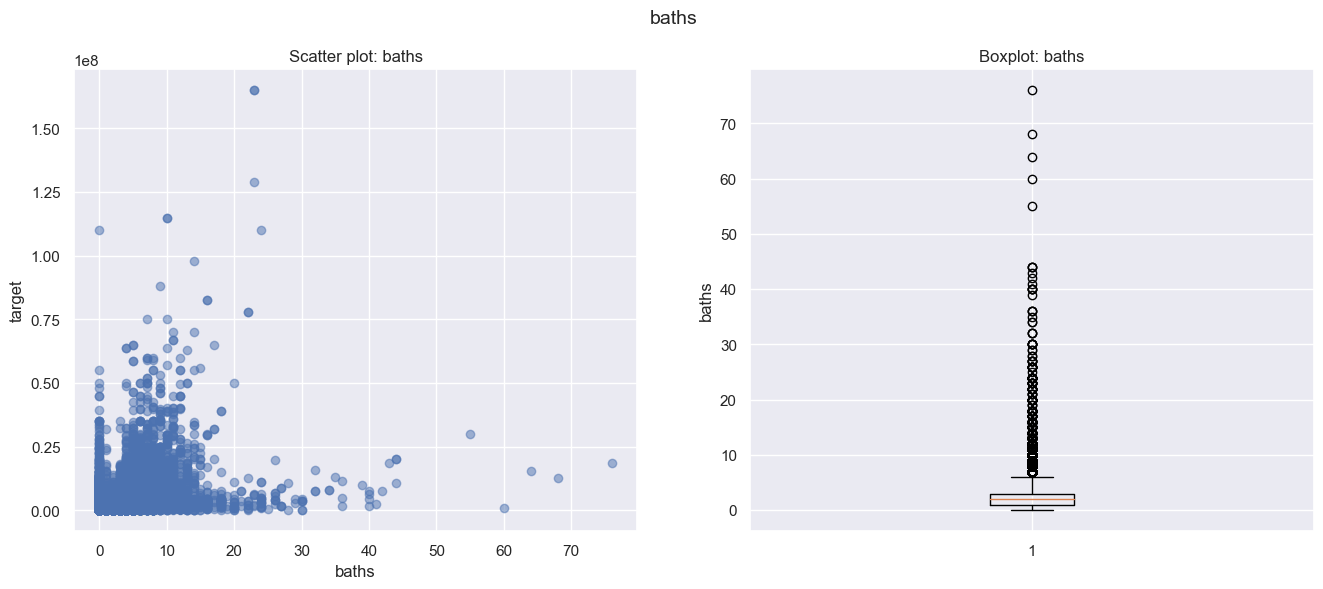

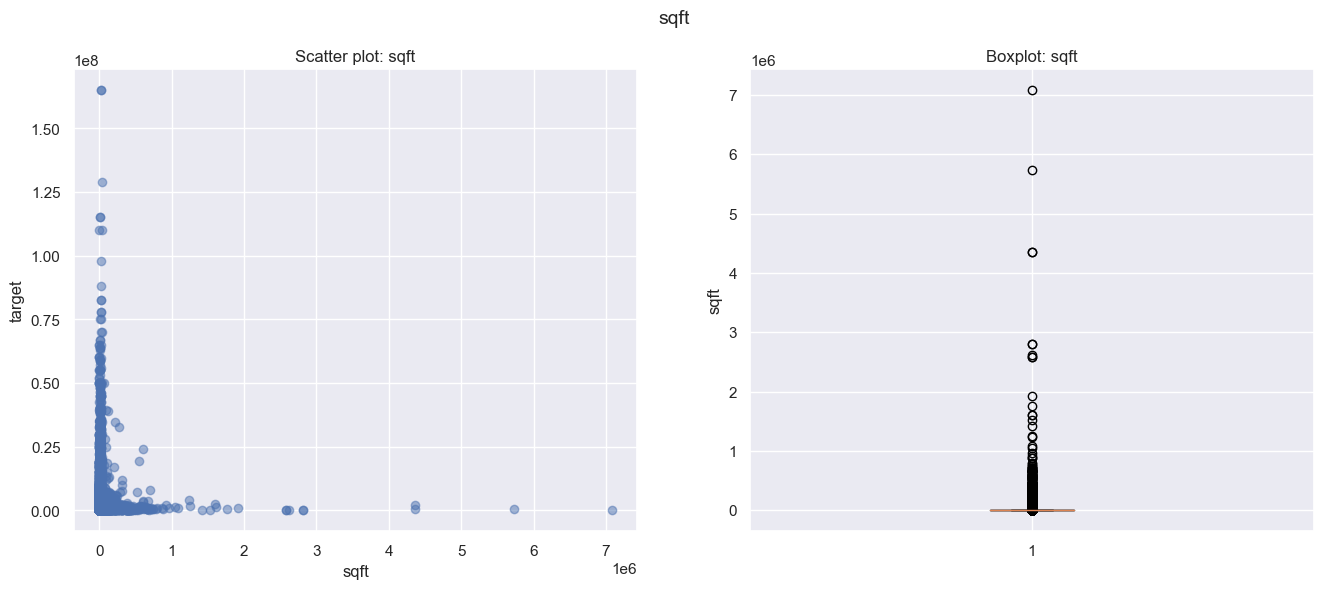

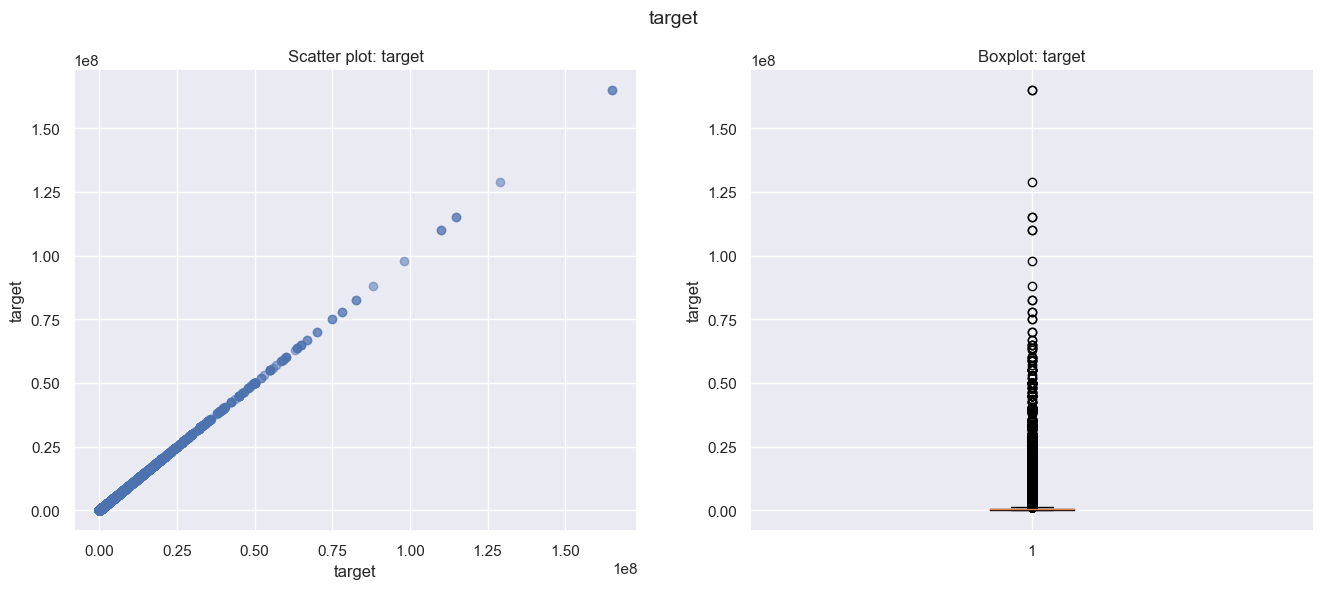

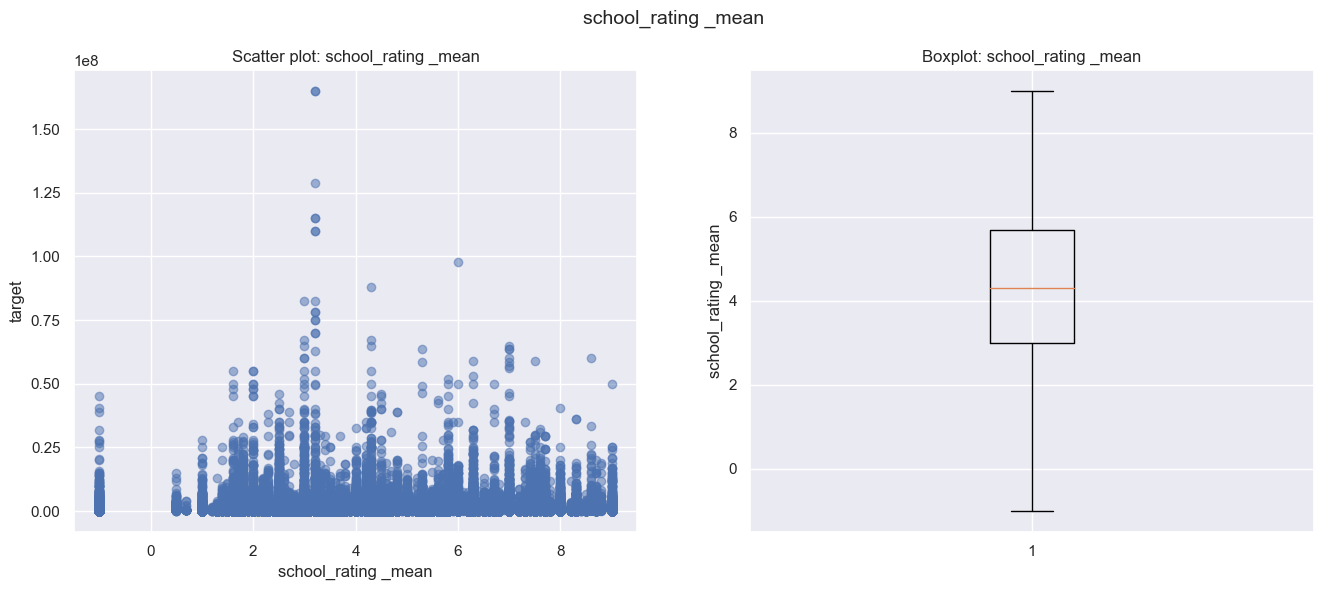

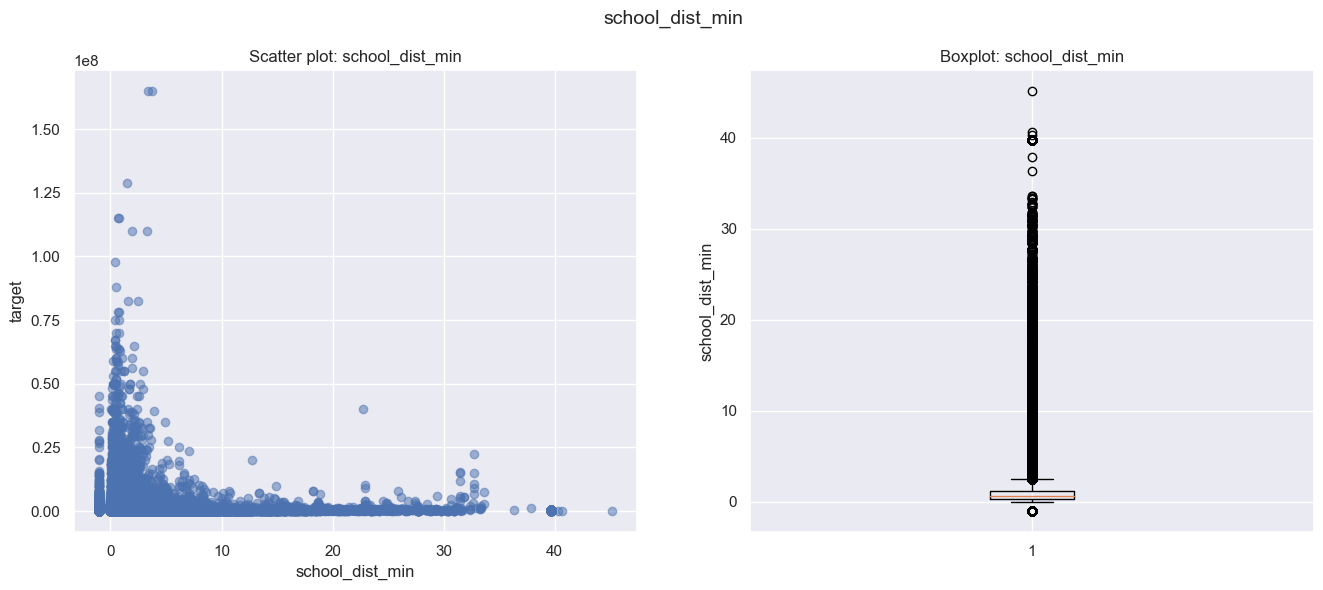

In [180]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Непонятные значения остались выведем и посчитаем сколько у нас таких значений

In [181]:
condition3 = ((df['baths'] > 30) | (df['target'] > 750000)) | (df['sqft'] > 200000) |(df['school_dist_min']> 35)
filtered3_df = df[condition3]
# Вывести отфильтрованные строки
print(len(filtered3_df))
display(filtered3_df)

59199


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,single_family_home,1961,True,True,True,True,6.7,1.19
3,For Sale,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,single_family_home,2006,True,True,True,True,5.6,0.10
14,For Sale,930 52nd St,0.0,Brooklyn,0,11219,NY,1650000,False,single_family_home,1905,False,True,False,False,6.3,0.20
16,Active,24 W 126th St,0.0,New York,3325,10027,NY,2650000,False,townhouse,1899,False,False,False,False,2.5,0.10
20,For Sale,61425 Gosney Rd,5.0,Bend,5266,97702,OR,3500000,False,single_family_home,2008,True,True,True,True,6.3,3.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331826,Other,3540 Palmetto Ave,3.0,Miami,1740,33133,FL,1450000,True,single_family_home,1938,True,True,True,False,2.0,1.10
331828,For Sale,24080 Tuscany Ct,5.0,Bonita Springs,5992,34134,FL,2495000,True,single_family_home,2006,True,False,True,True,5.5,2.06
331834,For Sale,1107 E Euclid Ave,0.0,San Antonio,950,78212,TX,799500,True,single_family_home,1938,True,True,False,False,4.0,0.25
331839,For Sale,2238 11th St NW APT 2,3.0,Washington,1417,20001,DC,799000,False,condo,2010,True,True,True,False,3.0,0.10


In [182]:
# Удаляем Выбросы, соответствующие условию
df.drop(df[condition3].index, inplace=True)

In [186]:
condition4 = ((df['baths'] < 1) | (df['sqft'] < 1))
filtered4_df = df[condition4]
# Вывести отфильтрованные строки
print(len(filtered4_df))
display(filtered4_df)

61724


,status,street,baths,city,sqft,zipcode,state,target,pool_encoded,Type,Year built,Heating_encoded,Cooling_encoded,Parking_encoded,fireplace_encoded,school_rating _mean,school_dist_min
4,For Sale,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,townhouse,1920,True,True,False,False,-1.0,-1.00
5,Active,552 Casanova Ct,0.0,Poinciana,1507,34759,FL,181500,False,other,2006,True,True,False,False,2.3,0.80
6,Active,6094 Mingle Dr,0.0,Memphis,0,38115,TN,68000,False,other,1976,False,False,False,False,2.7,0.40
10,Active,4222 False Cypress Ln,0.0,Houston,3130,77068,TX,260000,False,other,2015,True,True,False,False,4.2,0.40
34,For Sale,423 N Church St #13-A,0.0,Charlotte,900,28202,NC,260000,False,condo,1981,False,False,False,False,6.3,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331808,For Sale,206/208 N Randolph St,0.0,Indianapolis,0,46201,IN,50000,False,single_family_home,1910,False,False,False,False,1.0,0.43
331809,Active,1022 Lyndon Station Dr,0.0,Pineville,2058,28134,NC,342969,False,other,2020,False,True,False,False,6.3,0.20
331824,Foreclosure,460 Ovington Ave #1I,0.0,Brooklyn,520,11209,NY,246900,False,condo,1950,False,False,False,False,6.0,0.12
331829,For Sale,653 NE 15th Ter,0.0,Gainesville,1740,32641,FL,110000,False,single_family_home,1945,True,False,True,False,4.0,1.83


In [187]:
# Удаляем Выбросы, соответствующие условию
df.drop(df[condition4].index, inplace=True)

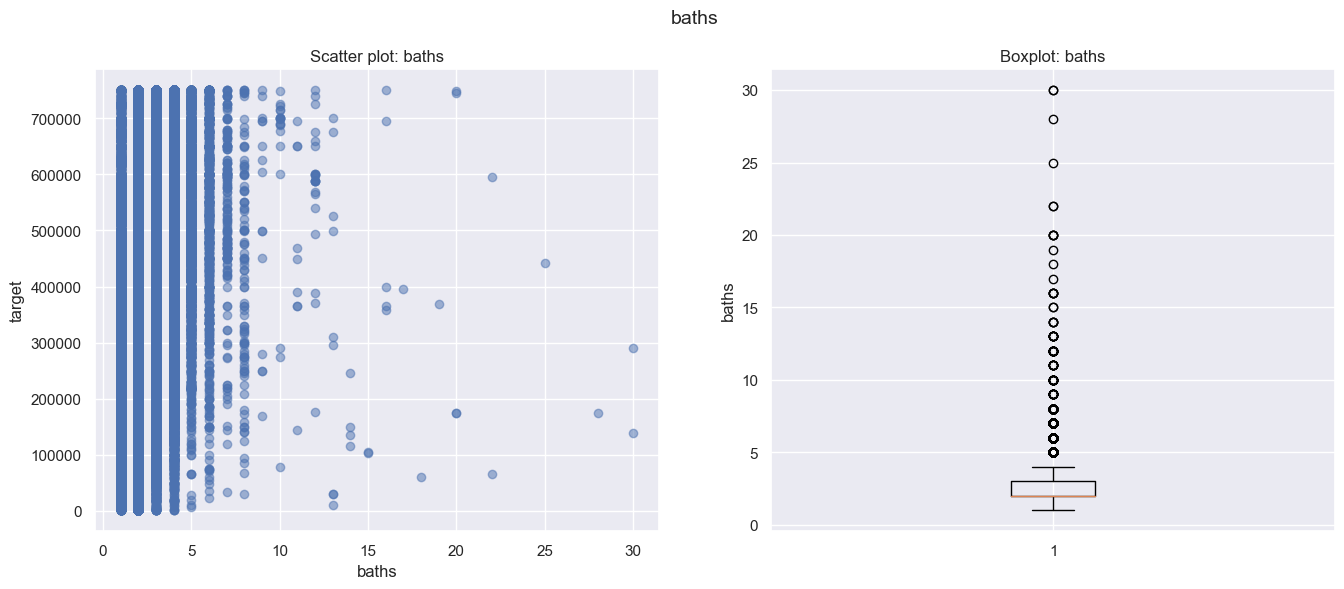

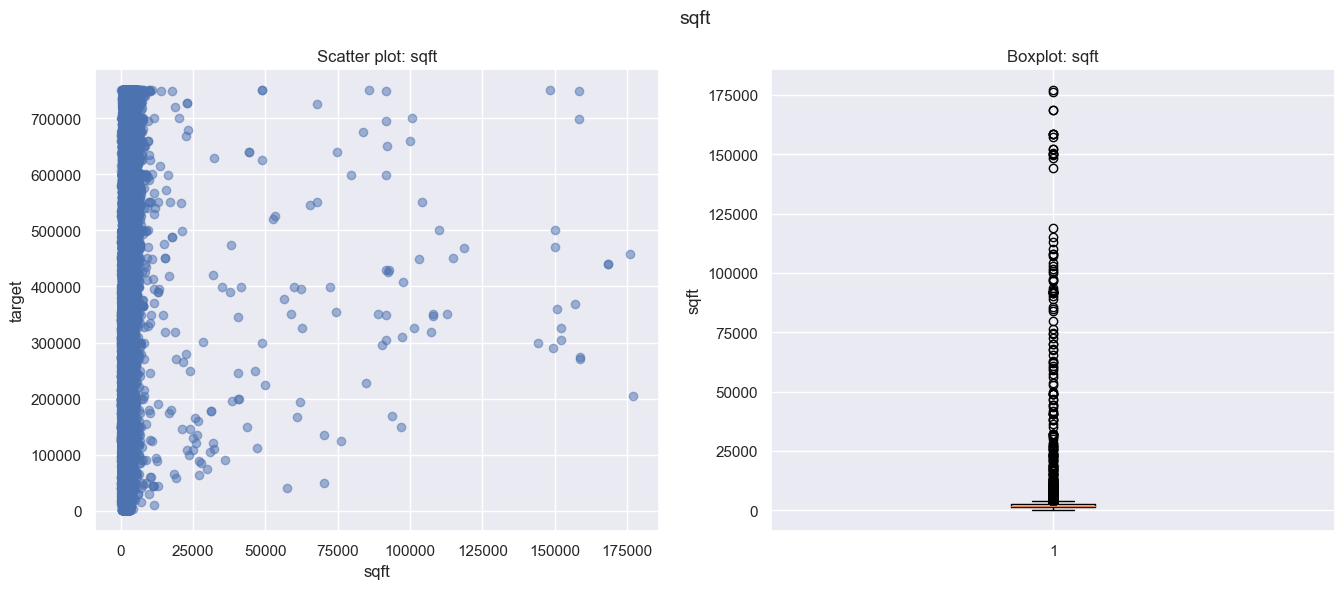

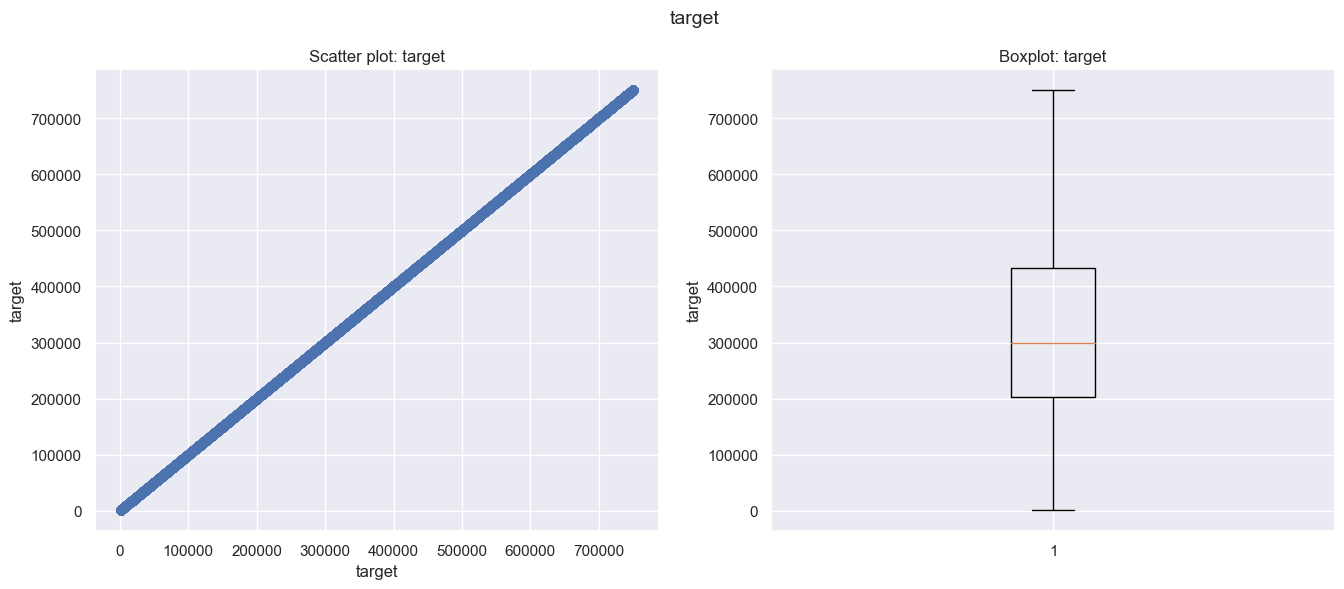

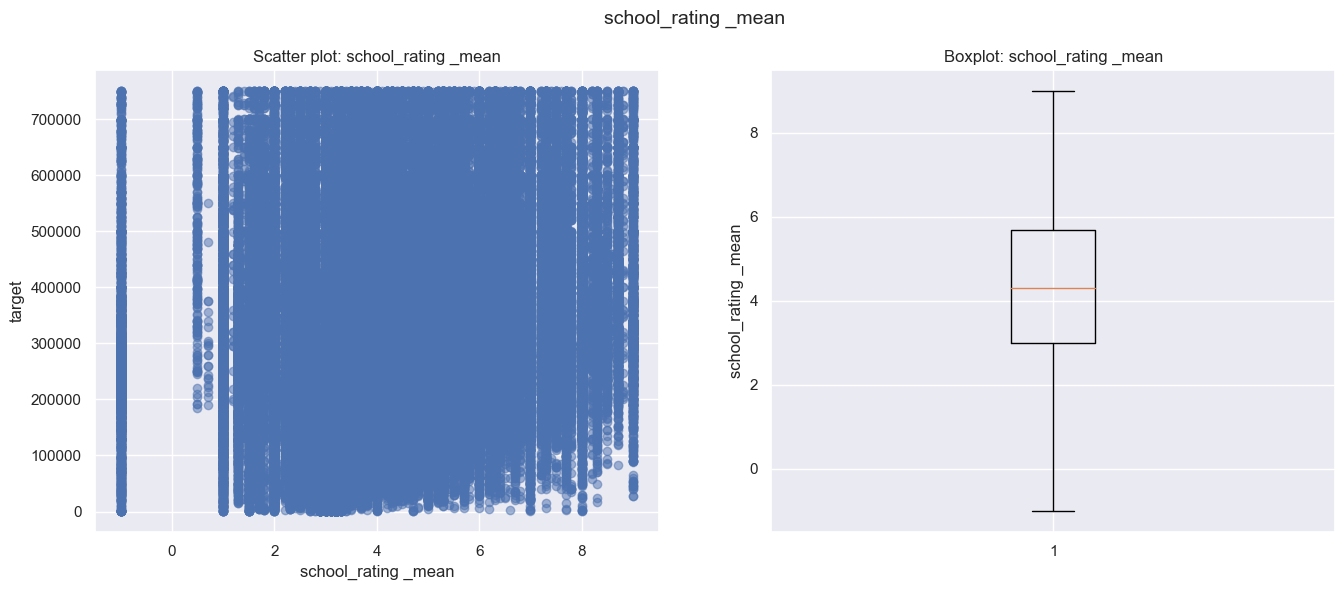

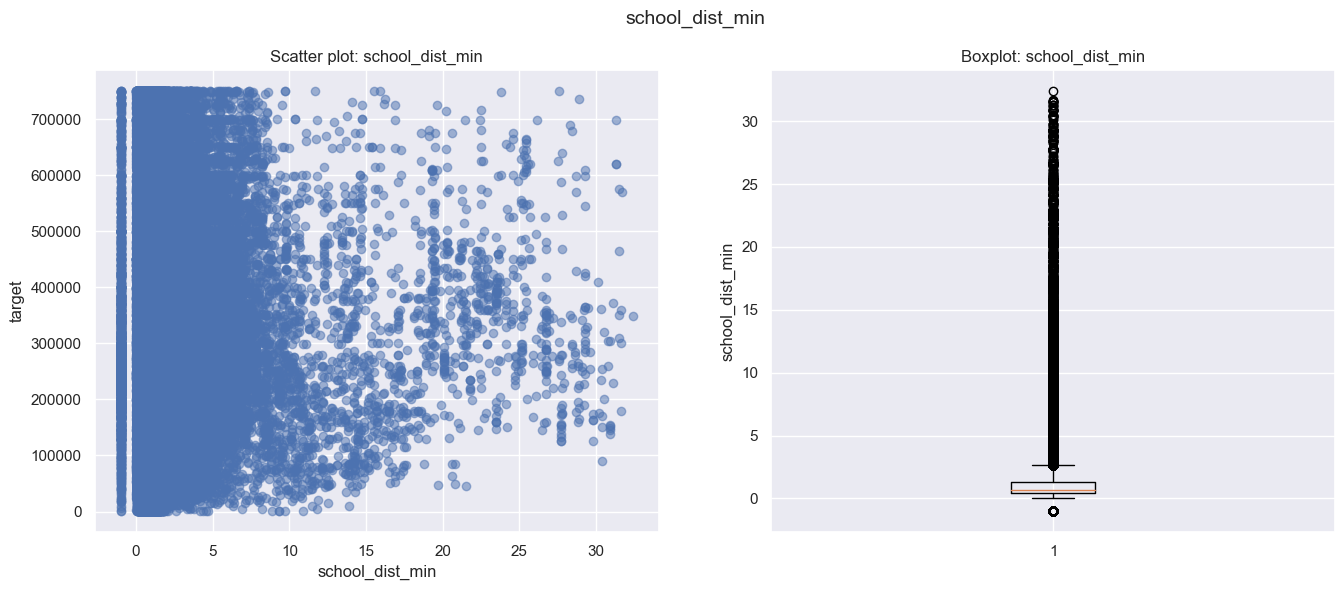

In [188]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

In [189]:
# удалим признак street
df = df.drop(columns=['street'], axis=1)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210669 entries, 0 to 331843
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               210669 non-null  object 
 1   baths                210669 non-null  float64
 2   city                 210669 non-null  object 
 3   sqft                 210669 non-null  int64  
 4   zipcode              210669 non-null  object 
 5   state                210669 non-null  object 
 6   target               210669 non-null  int64  
 7   pool_encoded         210669 non-null  bool   
 8   Type                 210669 non-null  object 
 9   Year built           210669 non-null  object 
 10  Heating_encoded      210669 non-null  bool   
 11  Cooling_encoded      210669 non-null  bool   
 12  Parking_encoded      210669 non-null  bool   
 13  fireplace_encoded    210669 non-null  bool   
 14  school_rating _mean  210669 non-null  float64
 15  school_dist_min      2

Посморим на распределение признаков

In [ ]:
# Отбираем только нужные признаки из датасета
#data_selected = df[num_features]
# Строим линейную регрессию для выбранных признаков
#sns.pairplot(data_selected, kind='reg')
#Добавляем заголовок
# plt.title('Линейная регрессия для выбранных признаков')
# Сохраняем график в файл с расширением PNG
#plt.savefig('image/plot.png', format='png')
# Отображаем график
#plt.show()
#закоментируем код ибо он очень долго выполняется вывод подкрепляю

![](image/plot.png)

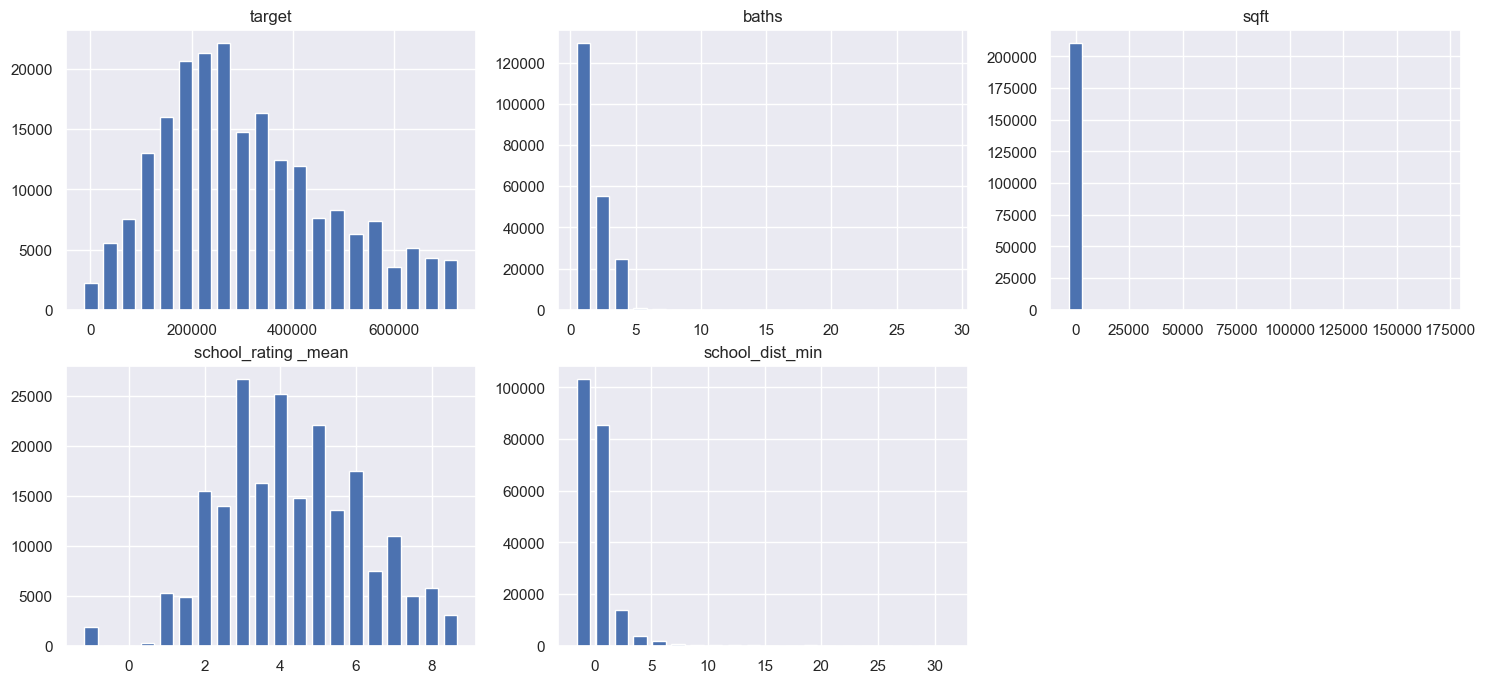

In [197]:
visualize_distributions({
    'target': df['target'],
    'baths': df['baths'],
    'sqft': df['sqft'],
    'school_rating _mean': df['school_rating _mean'],
    'school_dist_min': df['school_dist_min'],
})

Видим, что числовые признаки необходимо будет нормализовть и логорифмировать для получения нормального распределения.

Ранг матрицы корреляций: 5
Определитель матрицы корреляций: 0.7559163


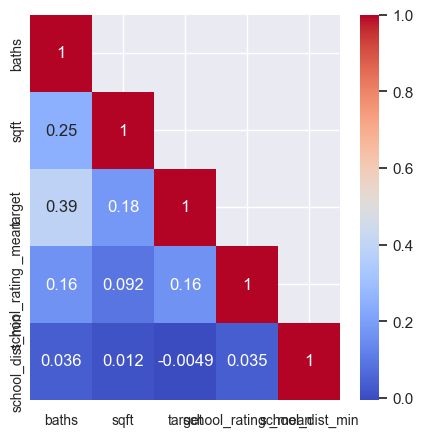

In [203]:
# Проверяем на мультиколлинеарность и корреляцию числовых признаков между собой и с главным признаком "target":
# строим матрицу корреляций
corr_matrix = np.corrcoef(df[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.7f}'.format(np.linalg.det(corr_matrix)))

# формируем нижний треугольник матрицы корреляций
corr_matrix_tril = np.tril(corr_matrix)
# заполняем верхний треугольник значениями NaN
corr_matrix_tril[corr_matrix_tril == 0] = np.nan

# создаем фигуру с автоматическим масштабированием
plt.figure(figsize=(len(df[num_features].columns), len(df[num_features].columns)))

# строим тепловую карту
sns.heatmap(corr_matrix_tril, annot=True, cmap='coolwarm', mask=np.isnan(corr_matrix_tril))
# добавляем подписи столбцов на тепловой карте
plt.xticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, rotation=0, ha='center', fontsize=10)
plt.yticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, ha='center', fontsize=10, va='center', rotation=90)
# отображаем график
plt.show()

Мультиколлинеарность отсутствует

## Анализ номинативных переменных
Посмотрим на распределение стоймости квартир в зависимости от значения номинативных переменных.

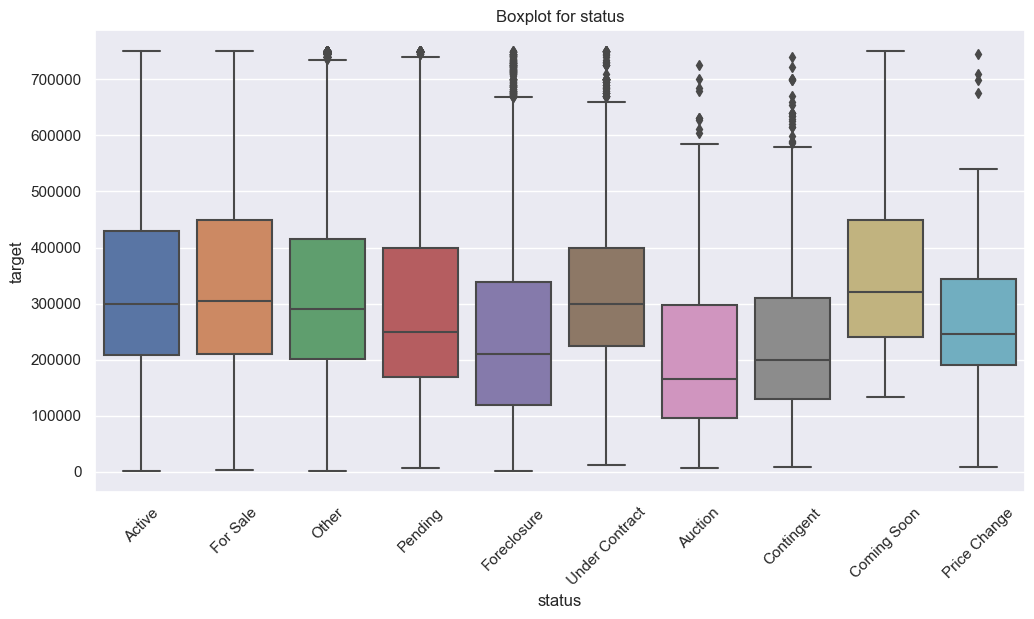

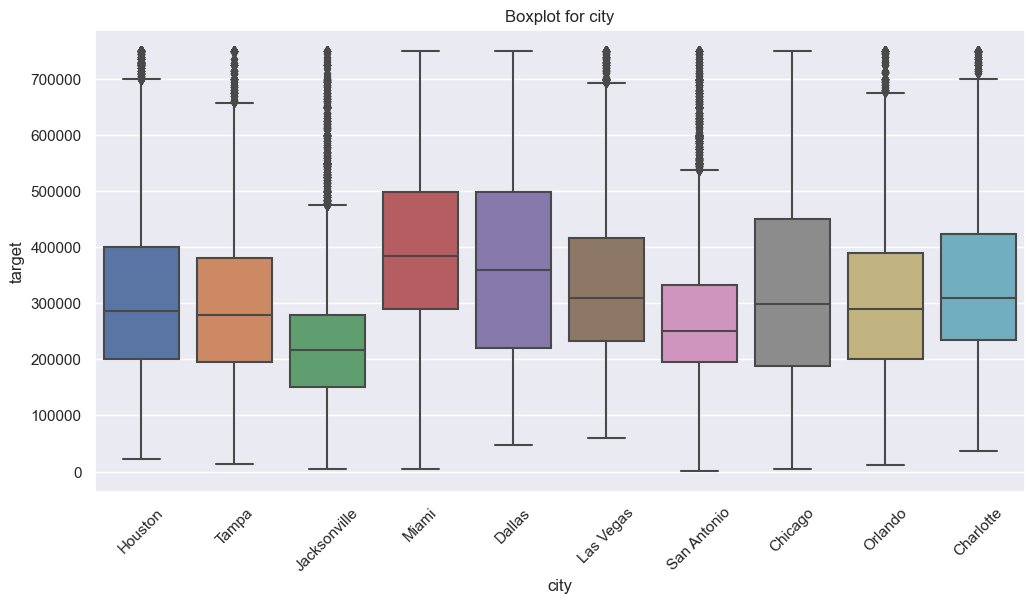

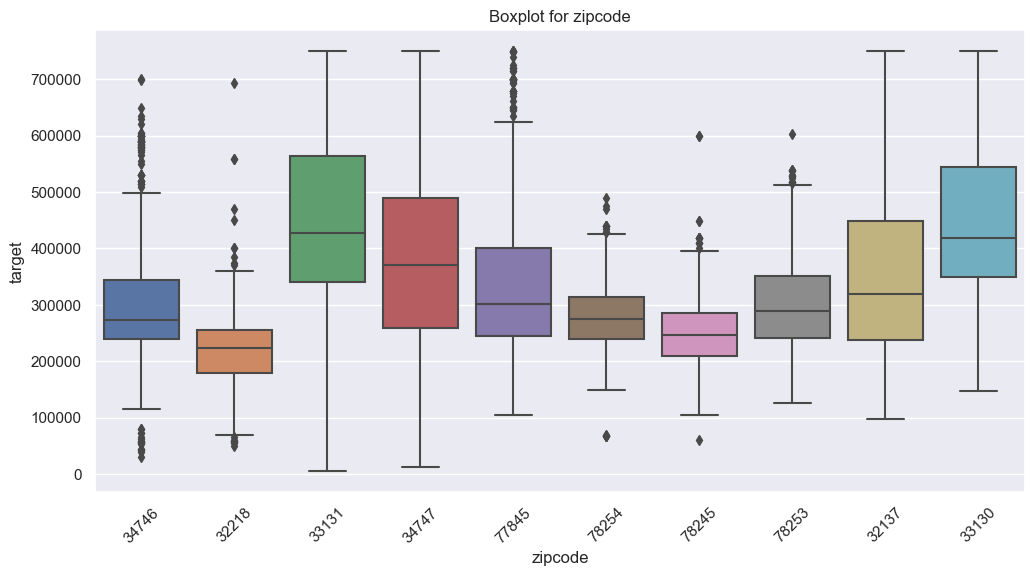

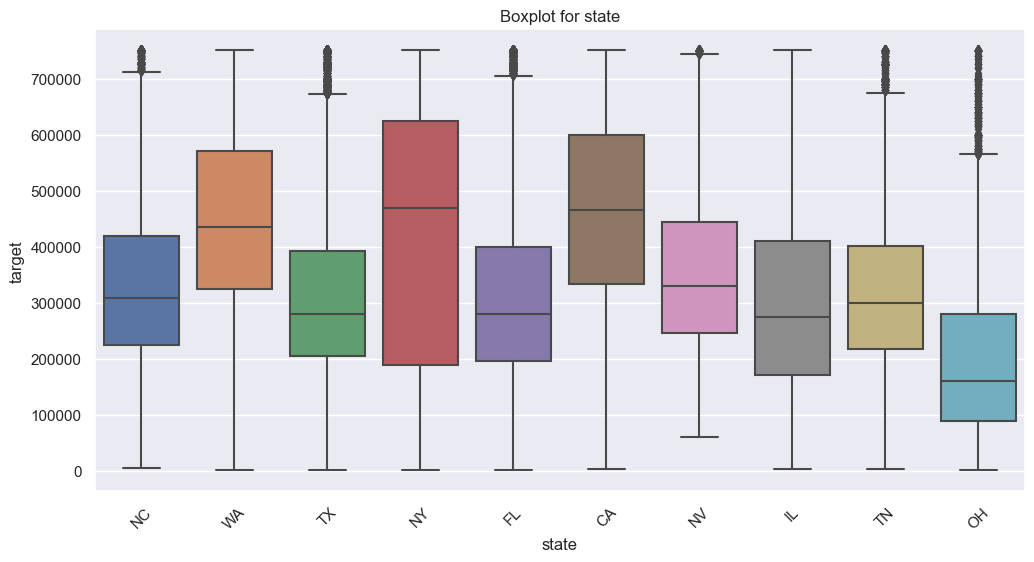

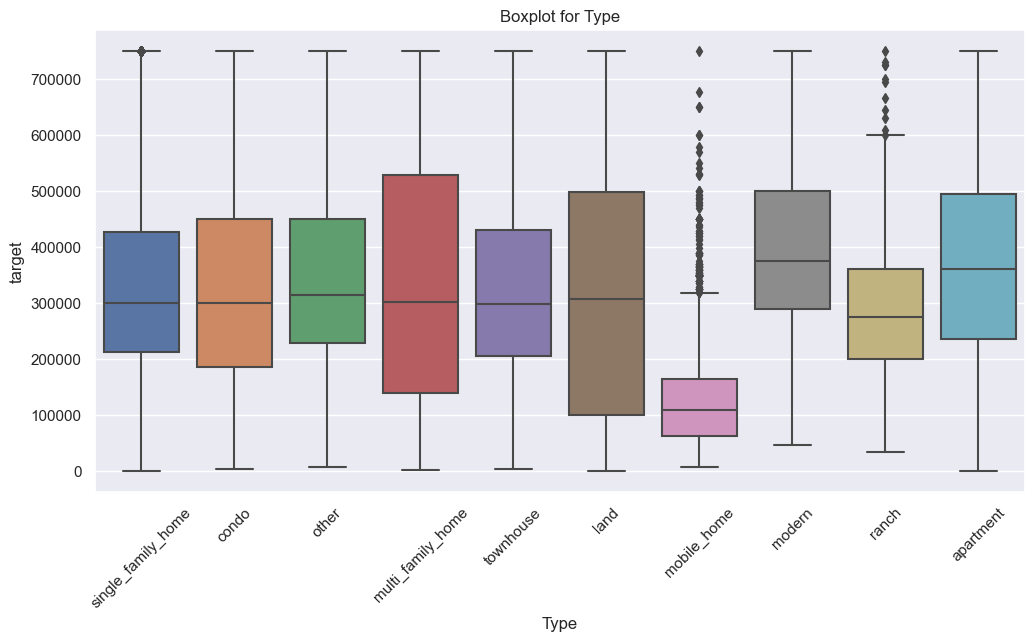

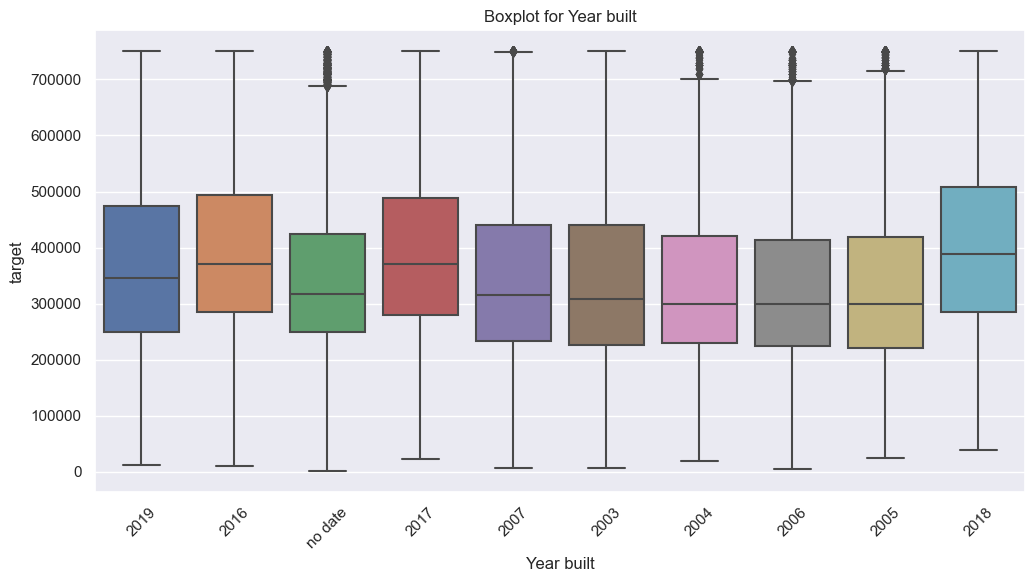

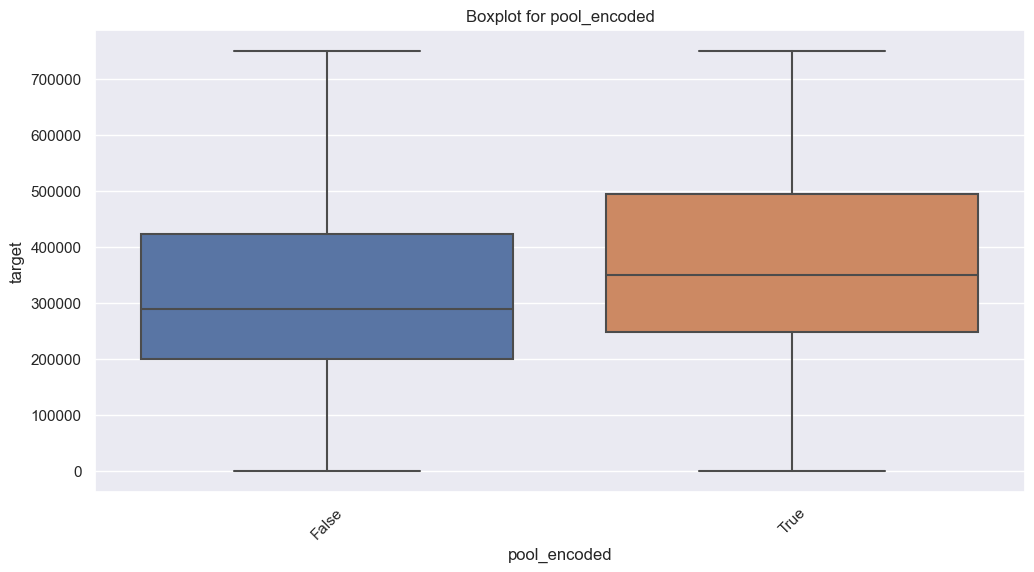

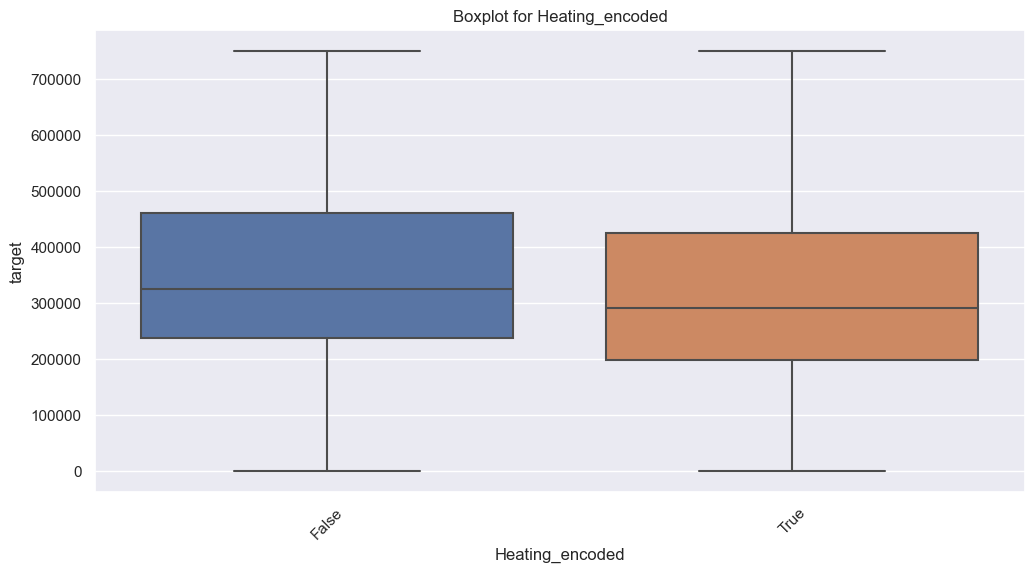

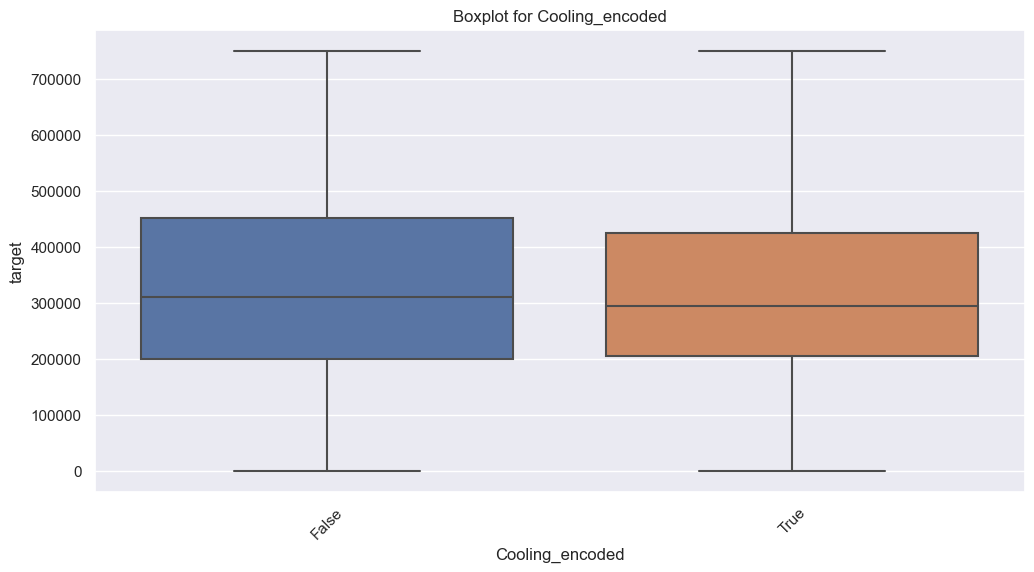

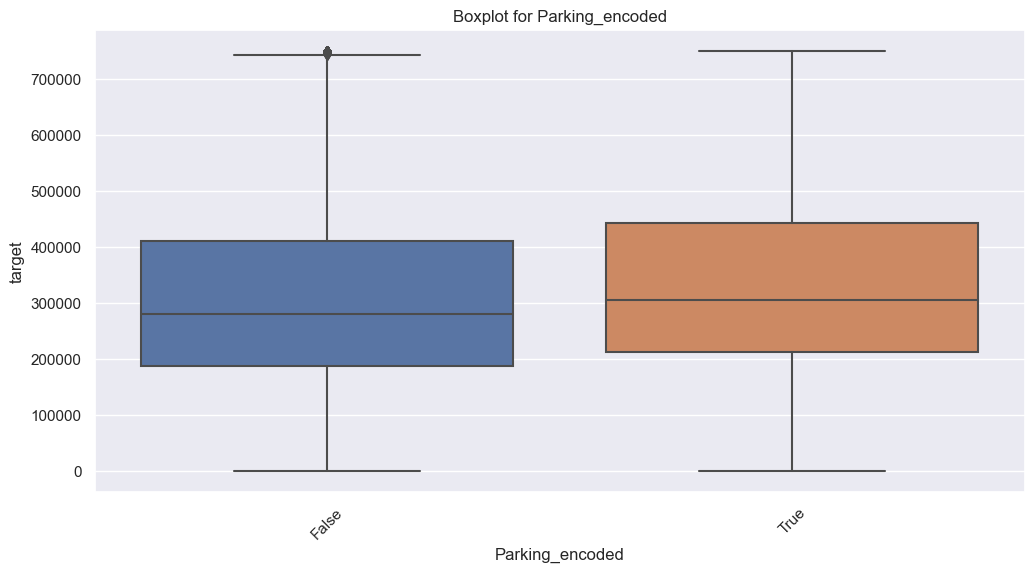

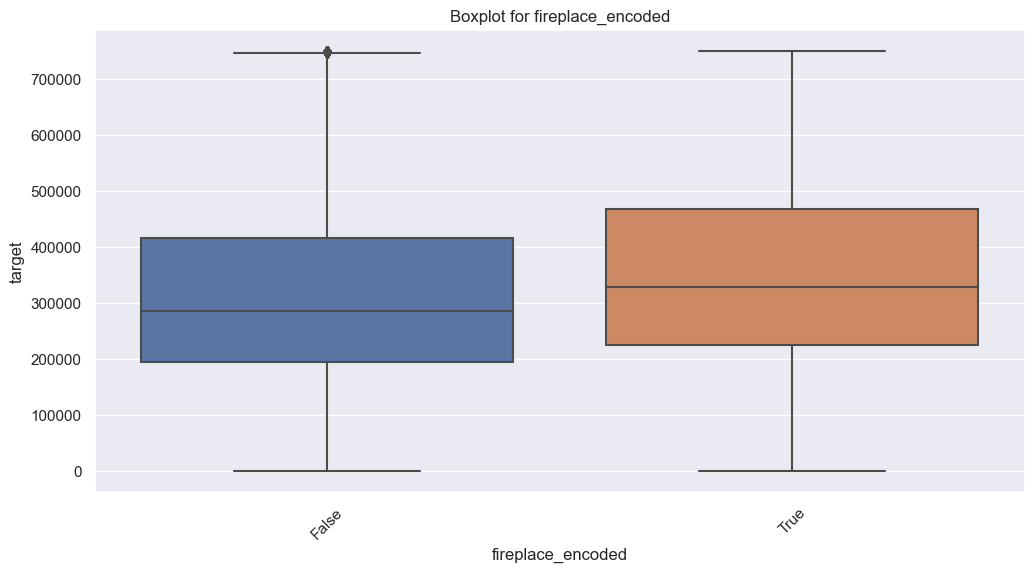

In [204]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

По графикам похоже, что все параметры, могут влиять на стоимость.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости недвижимости по различным параметрам неразличимы:.

In [205]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'target'], 
                        df.loc[df.loc[:, column] == comb[1], 'target']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [206]:
for col in chain(cat_features, bin_features):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки status
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки zipcode
Найдены статистически значимые различия для колонки state
Найдены статистически значимые различия для колонки Type
Найдены статистически значимые различия для колонки Year built
Найдены статистически значимые различия для колонки pool_encoded
Найдены статистически значимые различия для колонки Heating_encoded
Найдены статистически значимые различия для колонки Cooling_encoded
Найдены статистически значимые различия для колонки Parking_encoded
Найдены статистически значимые различия для колонки fireplace_encoded


Видим что все признаки являются значимыми

# Результаты EDA

В результате EDA мы проделали следующую работу:
* Избавились от пропусков влияющих на целевую переменную.
* Избавились от выбросов.
* Провели корреляционный анализ числовых признаков.
* Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
* Провели анализ номинативных переменных.

Сохраним датасет для дальнейшего использования при обучении модели.

In [208]:
df.to_csv('data/data_model.csv', index=False)